## Der Arbeitsplan des gesamten Systems sieht ungefähr wie folgt aus:

<img src='assets/pl.JPG' width=100% />

Das von der Kamera aufgenommene Bild wird an CNN (Erste künstliche Intelligenz)übermittelt. CNN entscheidet über Zustand der Anlage (0: gut oder 1: durstig). Die Entscheidung des CNN und die Werte des Bodenfeuchtesensors werden an das DNN (Zweite Künstliche Intelligenz) übermittelt. DNN (Dens Neural Network) ist darauf trainiert, viele Informationen auszuwerten. Eine Liste davon finden Sie oben.
   - 0: Es ist nicht notwendig, die Pflanzen zu gießen
   - 1: Es ist notwendig, die Pflanzen zu gießen
Schließlich wird das Relais mit einem einfachen Algorithmus gemäß der Entscheidung des DNN geöffnet oder geschlossen.

## 1. Notwendige Importe

Wir importieren die notwendigen Python-Bibliotheken, um unser Projekt auszuführen.

In [1]:
import torch
from torchvision import transforms, models
from torch import nn
import numpy as np
import cv2   # pip install opencv-python==3.3.0.9
from PIL import Image
import pandas as pd
import time

## 2. Pflanzenklassifizierung (Erste künstliche Intelligenz)
Um das zuvor trainierte Modell zu verwenden, importieren wir es und laden die Modellgewichte.

Zur Klassifizierung haben wir die Transfer Learning Methode verwendet. Als Modell wurde densenet121 gewählt. Wenn der folgende Code ausgeführt wird, werden Modellparameter auf den Computer heruntergeladen (falls erforderlich).

In [2]:
# use densenet121 as model
model = models.densenet121(pretrained=True)
# freez model parameters
for param in model.parameters():
    param.requires_grad = False
# make the classifier part of the model suitable for our project
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))
# !! This is important. Bring model in to test mode
model.eval()
# Load best weights that before has been trained
model.load_state_dict(torch.load('transferlearning_model.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

Um die Details des Modells anzuzeigen, lassen Sie diese Zelle bitte unkommentiert und führen Sie sie aus.

In [3]:
# model

Wir schreiben eine Funktion, die das Foto der Pflanze als Argument nimmt und den Zustand der Pflanze (gut oder dehydriert) mit unserem Modell der künstlichen Intelligenz festhält.

Unsere Funktion gibt **0** für einen **guten** Zustand und **1** für einen **dehydrierten** Zustand zurück.

In [4]:
class_names = ['good', 'thirsty']

def predict_plant_situation(img):
    # Check if it's a array of picture or a path of picture
    if isinstance(img, str):        
        # load the image from path
        img = Image.open(img, mode='r')
    else:
        # convert image array in to PIL image
        img = Image.fromarray(img)
    # normalize picture    
    img_transform = transforms.Compose([
#                                         transforms.Resize(255),
#                                         transforms.CenterCrop(224),
                                        transforms.ToTensor()
                                        ])
    img = img_transform(img)
    # reshape the picture for the model
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))    
    # pass the picture from model
    model.eval()
    output = model(img)
    # if you want to use index of pred
    _, pred = torch.max(output, 1)
    # if you want to use label 
#     pred = class_names[np.squeeze(output.data.max(1, keepdim=True)[1])]         
    
    return pred

Die folgende Funktion nimmt Bilder mit Hilfe einer an den Computer angeschlossenen Webcamera auf. Mit dieser Funktion machen wir ein Foto der Pflanze.

In [5]:
# take a picture from webcam
def get_image(camera=0):
    cap = cv2.VideoCapture(camera)
    cap.set(3,640) # adjust width
    cap.set(4,480) # adjust height
    time.sleep(4)
    success, img = cap.read()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cap.release()
    plt.imshow(img)
    return img

Jetzt machen wir ein Foto und testen unsere Funktion, **get_image()**.

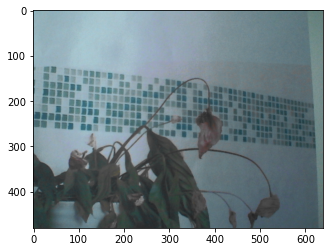

In [7]:
import matplotlib.pyplot as plt
img=get_image()
# print(img.shape)
# plt.imshow(img)

Hier schreiben wir eine Funktion, die das mit Hilfe von **get_image()** (oder aus einer Datei auf dem Computer) aufgenommene Pflanzenfoto als Argument an **optimize_plant_situation()** gibt und den Zustand der Anlage ( gut oder dehydrate ) einfriert.

In [8]:
def get_plant_situation(camera=0, path=0):
    if path==0:
        # get an image from webcam
        img = get_image(camera)
    else:
        # get an image from folder
        img = path
    return predict_plant_situation(img).numpy()[0]

Lassen Sie uns nun die Funktion get_plant_situation() testen.

0

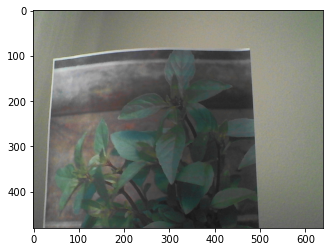

In [9]:
# img_path = r"C:\Users\Sahin\Documents\GitHub\equal_project\flowers\test\good\healthy_070.jpg"  # 0
# img_path = r"C:\Users\Sahin\Documents\GitHub\equal_project\flowers\test\thirsty\wilted_166.jpg"  # 1

# get_plant_situation(path=img_path)
get_plant_situation()

## 3. Entscheidungsträger (Zweite Künstliche Intelligenz)
Unser Klassifikator, den wir in diesem Abschnitt verwenden werden, ist ein Modell der künstlichen Intelligenz, das anhand verschiedene Daten entscheidet, ob die Pflanze gegossen werden soll oder nicht. Ich liste unten auf, welche Daten als Argument verwendet werden. Damit dieses Modell eine Entscheidung treffen kann, müssen ähnliche Informationen bereitgestellt werden.
 * 'season': Saison (1:Frühling, 2:Sommer, 3:Herbst, 4:Winter)
 * 'yr': Jahr (0: letztes Jahr, 1: dieses Jahr)
 * 'mnth': Monat (1 bis 12)
 * 'hr' : Stunde (0 bis 23)
 * 'b12h_weathersit' : Wetterlage vor 12 Stunden
        - 1: Klar, Sonnig
        - 2: Bewölkt, unterbrochene Wolken
        - 3: Leichter Schnee, leichter Regen
        - 4: Starker Regen + Eispaletten
 * 'b6h_weathersit' : Wetterlage vor 6 Stunden
 * 'b3h_weathersit' : Wetterlage vor 3 Stunden
 * 'crnt_weathersit': Aktuelle Wetterlage
 * 'a3h_weathersit' : Wettervorhersage after 3 Stunden
 * 'a6h_weathersit' : Wettervorhersage after 6 Stunden
 * 'a9h_weathersit' : Wettervorhersage after 9 Stunden
 * 'a12h_weathersit' : Wettervorhersage after 12 Stunden
 * 'temp' : Normalisierte Temperatur in Celsius. Die Werte werden auf 41 (max) geteilt 
 * 'atemp' : Normalisierte Gefühlstemperatur in Celsius. Die Werte werden auf 50 (max) geteilt 
 * 'hum' : Normalisierte Luftfeuchtigkeit. Die Werte werden durch 100 (max) geteilt
 * 'soil_hum' : Normalisierte Bodenfeuchte. Die Werte werden durch 100 (max) geteilt
 * 'windspeed' : Normalisierte Windgeschwindigkeit. Die Werte werden auf 67 (max) geteilt
 * 'CNN_decision' : Die Entscheidung der ersten künstlichen Intelligenz über den Zustand der Anlage
         - 0: gut
         - 1: durstig 

Wir haben eine solche Methode befolgt, um die Daten ordnungsgemäß auf das Modell zu übertragen. Wir speichern die Bearbeitungsinformationen, einschließlich der vom Modell während des Trainings verwendeten Grenzen, in einer CSV-Datei. Am Ende der Liste in dieser csv-Datei speichern wir die gerade erstellten Daten mit dem Namen example. Nachdem der Normalisierungsprozess abgeschlossen ist, nehmen wir die letzten normalisierten Daten und geben sie als Argument an unser Modell weiter.

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def run_nn(x, weights):
    output = sigmoid(np.dot(x, weights))
    return np.rint(output)
def decider(weights, CNN_decision, s_humidity, csv_path = 'temporary_data_.csv'):
    example = {
           'season': [2],
           'yr': [0], 
           'mnth': [7],
           'hr': [18], 
           'b12h_weathersit': [2],
           'b9h_weathersit': [2], 
           'b6h_weathersit': [2],
           'b3h_weathersit': [2], 
           'crnt_weathersit': [2],
           'a3h_weathersit': [2], 
           'a6h_weathersit': [2],
           'a9h_weathersit': [2], 
           'a12h_weathersit': [2],
           'temp': [0.5], 
           'atemp': [0.5],
           'hum': [s_humidity], 
           'soil_hum': [s_humidity],
           'windspeed': [0.2], 
           'CNN_decision': [CNN_decision]
          }
    # convert dictionary to pandas dataframe
    example = pd.DataFrame.from_dict(example)
    # add example to csv file
    example.to_csv(csv_path, mode='a', header=False)
    # read csv file
    rides = pd.read_csv(csv_path)
    # normalize data
    dummy_fields = ['season', 'b12h_weathersit', 'b9h_weathersit', 'b6h_weathersit', 'b3h_weathersit', 
                'crnt_weathersit', 'a3h_weathersit', 'a6h_weathersit', 'a9h_weathersit', 'a12h_weathersit', 
                'mnth', 'hr']
    for each in dummy_fields:
        dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
        rides = pd.concat([rides, dummies], axis=1)
    fields_to_drop = ['instant',  'season', 'b12h_weathersit', 'b9h_weathersit', 'b6h_weathersit', 'b3h_weathersit', 
                    'crnt_weathersit', 'a3h_weathersit', 'a6h_weathersit', 'a9h_weathersit', 'a12h_weathersit', 
                    'mnth', 'hr', 'conclusion']
    data = rides.drop(fields_to_drop, axis=1)
#     print(data)
    # Convert dataframe to numpy and get last data from list
    data = data.to_numpy()[-1]    
    # run second model to decition
    decition = run_nn(data, weights)
    
    return decition
    

Wir laden die Gewichte, die wir als Ergebnis des Trainings erhalten haben, in unser Modell.

In [11]:
# load trained weights from path
weights = np.loadtxt('nn_weights.csv', delimiter=',')

In diesem Abschnitt werden wir die Daten, die wir von den Sensoren und der ersten künstlichen Intelligenz erhalten haben, in unser Dictionary '{}' aufnehmen. Andere Daten wurden angepasst, um das Modell nicht zu beeinflussen.

1.0

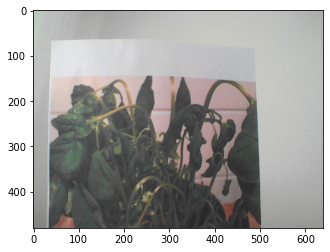

In [13]:
decider(weights, 
        CNN_decision = get_plant_situation(),        
        s_humidity = 0.8,
        csv_path = 'temporary_data_.csv')

## 4. Arduino

Lassen Sie uns die notwendige Bibliothek importieren, um den Arduino zu steuern. Es ist notwendig, vorher die firmta-Standardbibliothek auf den Arduino hochzuladen. [Hier](https://realpython.com/arduino-python/#:~:text=pySerial%3A%20Arduino%20Uno%20cannot%20run,Python%20using%20your%20own%20protocol.) finden Sie grundlegende Informationen zur Verwendung von Arduino mit Pyfirmata.

In [49]:
import pyfirmata

## Schaltplan von Arduino und Sensoren

<img src='assets/arduino_cct.JPG' width=60% />

In [50]:
# connect to Arduino
board = pyfirmata.Arduino('Com4')
# get messages from Arduino
it = pyfirmata.util.Iterator(board)
it.start()
# set sensors
water_sensor = board.get_pin('a:0:i')
relay = board.get_pin('d:13:o')

In [ ]:
cap = cv2.VideoCapture(0)
cap.set(3,640) # adjust width
cap.set(4,480) # adjust height
model.eval()
while True:
    time.sleep(1)
    success, img = cap.read()
#     cv2.imshow("Webcam", img) # This will open an independent window
    if cv2.waitKey(1) & 0xFF==ord('q'): # quit when 'q' is pressed
        cap.release()
        break
    # Get a plant picture from path
    # CNN_decision = predict_plant_situation(img).numpy()[0]
    # Get a plan picture from kamera
    CNN_decision = get_plant_situation()
    soil_humidity = water_sensor.read()
    decision = decider(weights, 
                       CNN_decision = CNN_decision,
                       s_humidity = 0.51,
                       csv_path = 'temporary_data_.csv'
                      )
    print("decision :", decision, "soil_humidity: ",soil_humidity, "CNN_decision", CNN_decision)
    if decision:        
        relay.write(1)
        time.sleep(10)
        relay.write(0)
    time.sleep(1)
cv2.destroyAllWindows()

In [14]:
%%HTML
<video width="640" height="480" controls>
  <source src="test.mp4" type="video/mp4">
</video>